In [33]:
import numpy as np
from variational_staple.unordered import staple, vstaple

In [34]:
# We define the true performance of 4 raters tasked to classify "things"
# between three classes. Since they are not perfect raters, they
# have a probability of classifiying a "thing" as A even though it was B.
# Each performance matrix gives the probability of rater n of choosing
# class A when it should have been B:
#   true_perf[n, A, B] = P(rater [n] says A | true class is B)
true_perf = [
    np.eye(3),                                              # rater 1 (perfect)
    [[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]],    # rater 2 (imperfect)
    np.ones([3, 3]) / 3,                                    # rater 3 (chance)
    [[0.1, 0.8, 0.1], [0.8, 0.1, 0.1], [0.1, 0.1, 0.8]],    # rater 4 (confused)
]
true_perf = np.asarray(true_perf)

# check that columns sum to one
print('Raters\' confusion')
print(true_perf)

Raters' confusion
[[[1.         0.         0.        ]
  [0.         1.         0.        ]
  [0.         0.         1.        ]]

 [[0.8        0.1        0.1       ]
  [0.1        0.8        0.1       ]
  [0.1        0.1        0.8       ]]

 [[0.33333333 0.33333333 0.33333333]
  [0.33333333 0.33333333 0.33333333]
  [0.33333333 0.33333333 0.33333333]]

 [[0.1        0.8        0.1       ]
  [0.8        0.1        0.1       ]
  [0.1        0.1        0.8       ]]]


In [35]:
# sample true classes
true_prop = [0.7, 0.2, 0.1]
n = 10000
true_classes = np.random.multinomial(1, true_prop, n).argmax(axis=1)   # [N]

print('Sample of true classes')
print(true_classes[:10])

# sample the raters' choice using the confusion matrices
conditional_confusion = true_perf[:, :, true_classes].transpose(2, 0, 1)          # [N, R, K]
ratings = [np.random.multinomial(1, conditional_confusion[i, j]).argmax()
           for i in range(n) for j in range(len(true_perf))]
ratings = np.asarray(ratings).reshape(n, len(true_perf))

print('Sample of ratings')
print(ratings[:10].T)

Sample of true classes
[0 2 2 0 0 2 0 0 2 0]
Sample of ratings
[[0 2 2 0 0 2 0 0 2 0]
 [0 2 0 0 0 2 0 1 2 0]
 [1 0 0 2 2 2 2 2 1 1]
 [1 2 2 1 0 2 1 1 2 0]]


In [36]:
# Fit using STAPLE

perf, posterior, prior = staple(ratings)

print('Estimated confusion matrices')
print(np.around(perf, 1))

print('Estimated class proportions')
print(np.around(prior, 1))

Estimated confusion matrices
[[[1.  0.  0.1]
  [0.  1.  0. ]
  [0.  0.  0.9]]

 [[0.8 0.1 0.1]
  [0.1 0.8 0.1]
  [0.1 0.1 0.8]]

 [[0.3 0.3 0.3]
  [0.3 0.3 0.4]
  [0.3 0.3 0.3]]

 [[0.1 0.8 0.1]
  [0.8 0.1 0.1]
  [0.1 0.1 0.8]]]
Estimated class proportions
[0.7 0.2 0.1]


In [37]:
# Fit using V-STAPLE (a variant of MAP-STAPLE)

perf, posterior, prior = vstaple(ratings)

print('Estimated confusion matrices')
print(np.around(perf, 1))

print('Estimated class proportions')
print(np.around(prior, 1))

Estimated confusion matrices
[[[1.  0.  0. ]
  [0.  1.  0. ]
  [0.  0.  0.9]]

 [[0.8 0.1 0.1]
  [0.1 0.8 0.1]
  [0.1 0.1 0.8]]

 [[0.3 0.3 0.3]
  [0.3 0.3 0.4]
  [0.3 0.3 0.3]]

 [[0.1 0.8 0.1]
  [0.8 0.1 0.1]
  [0.1 0.1 0.8]]]
Estimated class proportions
[0.7 0.2 0.1]


Estimated rater's variance (conditioned on truth)
[[3.33131675e-14 1.00212039e-02 2.28933949e-01]
 [3.33131675e-14 3.45024128e-04 1.65707328e-04]
 [6.66329520e-01 6.60158986e-01 6.63491231e-01]
 [1.31509556e-03 4.04986843e-02 2.42416055e-01]]


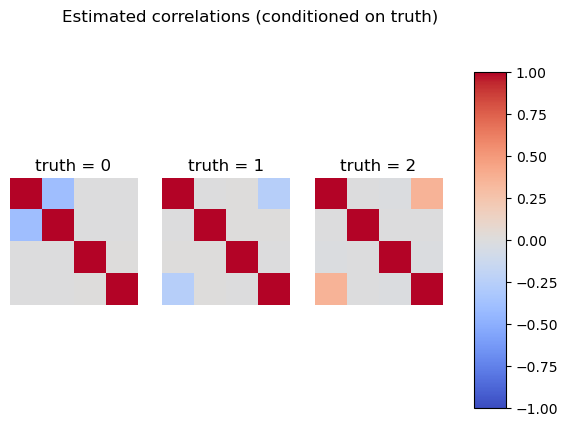

Estimated rater's marginal confusion matrices
[[[1.  0.  0.1]
  [0.  1.  0. ]
  [0.  0.  0.9]]

 [[1.  0.  0. ]
  [0.  1.  0. ]
  [0.  0.  1. ]]

 [[0.3 0.3 0.3]
  [0.3 0.4 0.4]
  [0.3 0.3 0.3]]

 [[0.  1.  0. ]
  [1.  0.  0.1]
  [0.  0.  0.9]]]


In [38]:
from variational_staple.correlated import \
    vcstaple, correlation_pairwise, marginal_pairwise
import matplotlib.pyplot as plt

# Fit using VC-STAPLE (learn correlations)

perf, posterior, prior = vcstaple(ratings)

# compute correlation
v, c = correlation_pairwise(perf)

print('Estimated rater\'s variance (conditioned on truth)')
print(v)

fig, axes = plt.subplots(1, 3)
for k, ax in enumerate(axes):
    plt.subplot(1, 3, k+1)
    p = plt.imshow(c[..., k], cmap='coolwarm', vmin=-1, vmax=1)
    plt.axis('off')
    plt.title(f'truth = {k}')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)
plt.suptitle('Estimated correlations (conditioned on truth)')
plt.show()


print('Estimated rater\'s marginal confusion matrices')
print(np.around(marginal_pairwise(perf), 1))